<hr style="border: 1px solid black; width: 100%; margin-left: 0">


<div style="text-align:right"> <b>University of Padua - Department of Physics and Astronomy<b> </div> 
<div style="text-align:right"> <strong> Degree course: </strong> Physics of Data</div>
<div style="text-align:right"><strong>Course: </strong>Information Theory and Inference<b> </div>
<div style="text-align:right"><strong>Year: </strong>2024-2025<b> </div>
    

#### Students:
- Bertinelli Gabriele - 2103359 - gabriele.bertinelli@studenti.unipd.it
- Lovato Matteo - 2104269 - matteo.lovato.3@studenti.unipd.it

    
<strong>Exam Date</strong>: February, 21st 2025
    
<center>
    
# Approximate Bayes Computation: application on the SIR model
<center>
<hr style="border: 1px solid black; width: 100%; margin-left: 0">   

In [2]:
from PIL import Image

## SIR Model

The **SIR model** is a mathematical tool to model the spreading of infectuous diseases. It is a stochastic model, including three possible states for a population:
- _susceptible_ (S): individuals who have not suffered of the disease yet;
- _infected_ (I): individuals who are currently suffering of the disease; 
- _recovered_ (R): individuals who have recovered o have died from the disease. 

SIR model describes the flow of individuals from S to I and then from I to R by a set of ordinary differential equations:
$$
\begin{cases}
\frac{dS(t)}{dt} &= -\beta S(t)P(t) \\
\frac{dI(t)}{dt} &= \beta S(t)P(t) - \gamma I (t) \\
\frac{dR (t)}{dt} &= \gamma I (t)
\end{cases}
$$
where $P(t)=I(t)/N$ is the proportion of infectuous individuals at time $t$, $\beta$ is the transmission rate parameter and $\gamma$ the removal rate parameter. The sum of $S(t)$, $I(t)$ and $R(t)$ gives at any moment the total population $N$. <u>**The goal of our work is to infer the parameters $\beta$ and $\gamma$**</u>.

We derived the model used in this analysis by the one proposed in [Gu J., Yin G. (2022)](https://www.nature.com/articles/s41598-022-25473-y).  
Let $\Delta I = (\Delta I_1,...,\Delta I_\text{T})^T $ and $\Delta R = (\Delta R_1,...,\Delta R_\text{T})^T $  be sequences of daily reported numbers of newly infected (confirmed) cases and removed cases respectively. Given the initial state of the population $(S_0,I_0,R_0)$, we write the discrete-time stochastic SIR model as follows:
$$
\begin{equation*}
\begin{cases}
\Delta I_t \sim \text{Binomial}\left(S_{t-1}, 1 - \exp(-\beta_t P_{t-1})\right) \\
\Delta R_t \sim \text{Binomial}\left(I_{t-1}, \gamma_t\right) \\
S_t = S_{t-1} - \Delta I_t \\
I_t = I_{t-1} + \Delta I_t - \Delta R_t \\
R_t = R_{t-1} + \Delta R_t
\end{cases}
\end{equation*}
$$

### "Observed" data
The shapes of the priors are the one considered in [Gu J., Yin G. (2022)](https://www.nature.com/articles/s41598-022-25473-y):

$$ \beta \sim Exp(\lambda=0.1)$$
$$\gamma \sim Beta(\alpha=0.01, \beta=1)$$

We generated a timeseries, i.e. our observed data, at fiducial parameter values

$$ \beta = 0.01 $$
$$ \gamma = 0.1 $$

The parameter values were chosen to be in line with typical values found in the literature.

Being it a stochastic model, the shape of the distribution is not fixed, rather it will have an "intrinsic" noise which will impact on the acceptance rate of the samples. However, usually this appears to be of small magnitude.

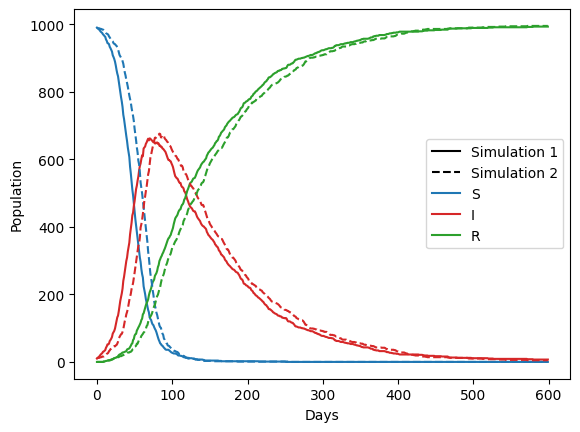

In [16]:
Image.open('./py_code/plot/SIR_sims.png')

## Approximate Bayesian Computation (ABC)

In statistical inference, there exist cases in which the likelihood $\mathcal{L}=\pi(d|\theta)$ may be unavailable, either because of mathematical or computational reasons.  
The ABC algorithm uses our ability to simulate physical process to bypass the necessity of a $\mathcal{L}$:

<!-- - We start with the usual Bayes theorem $\pi(\theta|d) \propto \pi(d|\theta)\,\pi(\theta)$
- It’s useful sometimes to include simulations to the real dataset and the theorem modifies as  
  $\pi(\theta,s|d) \propto \pi(d|\theta,s)\,\pi(s|\theta)\,\pi(\theta)$, where $\pi(s|\theta)$ is the <u>simulation model</u>.
- We end up to an approximate $\mathcal{L}$-free posterior $\Rightarrow$  
  $\pi_{LF}(\theta|d) \propto \pi(\theta)\,\int\pi(d|\theta,s)\,\pi(s|\theta) ds = \pi(\theta)\,\pi(d|\theta)$, since $\pi(d|\theta,s) \equiv \delta^D(d-s)$, i.e. the distance between the real data and the simulation. -->

It is based on the following elements:

- a simulator, or forward model
- prior distributions over the input parameters $\pi(\theta)$
- a distance function $\varrho(\mathcal{D}_1, \mathcal{D}_2)$
- a threshold $\varepsilon$

<!-- The main idea behind the ABC algorithm can be summarized in three main steps:

1. draw a large number of parameter values $\bm{\theta}^i$, from the prior distribution
2. $\forall \bm{\theta}^i$ generate a simulation $\mathcal{D}^i_S$ and calculate the distance between the observed to the simulated catalogues: $\rho_i=\rho(\mathcal{D}, \mathcal{D}^i_S)$
3. approximate the posterior distribution using the fraction of $\bm{\theta}^i$ with smallest associated distances. -->

### ABC - rejection sampler

Firstly, we implemented the "likelihood-free rejection sampler" algorithm in [Marin et al. (2011)](https://doi.org/10.1007/s11222-011-9288-2).

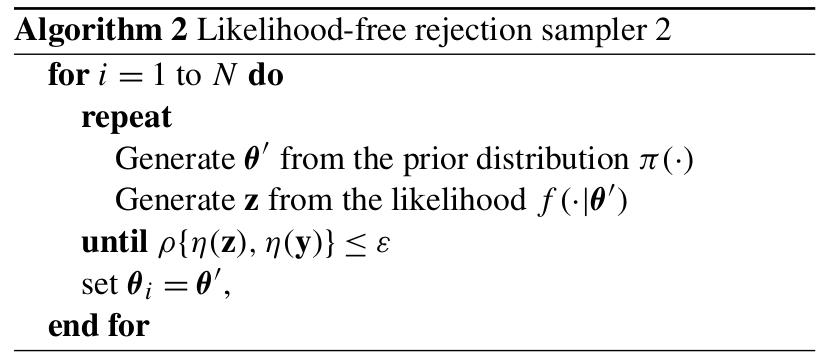

In [3]:
Image.open('./py_code/plot/abc_algo.png', )

In this case we selected the Euclidean distance, normalized by the population size just to have a more "manageable" number for the threshold $\varepsilon$.  
We run the algorithm for $\varepsilon = \{20, 18, 16, 14, 10, 6, 5, 3, 2, 1\}$. The algorithm stops when the number of accepted samples is 10.000.

<!-- ```c
// Compute distance between observed and simulated data (S,I,R arrays).
// d_S, d_I, d_R are normalized by population N.
void distance(int N, int ndays, int *obs_S, int *obs_I, int *obs_R, 
              int *sim_S, int *sim_I, int *sim_R,
              double *d_S, double *d_I, double *d_R) {
    *d_S = compute_norm(sim_S, obs_S, ndays) / N;
    *d_I = compute_norm(sim_I, obs_I, ndays) / N;
    *d_R = compute_norm(sim_R, obs_R, ndays) / N;
}
``` -->

#### **Computational Analysis**

As we decrease the threshold, the computation time increase ~ exponentially as the average number of trials (in order to find an accepted parameter), while the acceptance rate decreases:  
for $\varepsilon = \{3,2,1\}$ it's below $0.03\%$.

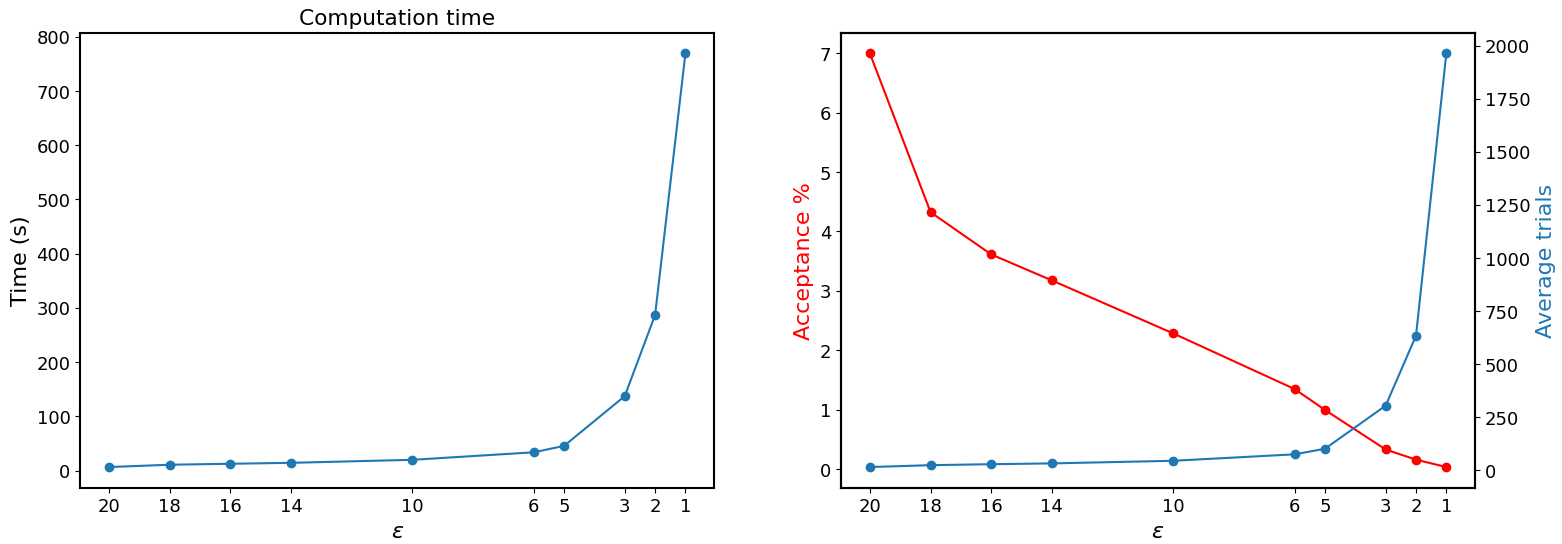

In [4]:
Image.open('./py_code/plot/comp_stats.png')

We want to see if there's a "sweet spot" for the threshold $\varepsilon$, the computation time and the inferred parameter median.  
A threshold of 14 seems to be a good compromise. We can also see that $\varepsilon=5$ could be also a good value. Thus we will consider $\epsilon = 14, 5$ for our analysis.  
The computation time for $\varepsilon=14$ is $\simeq 14.2\,s$, while for $\varepsilon=5$ is $\simeq 45.5\,s$.

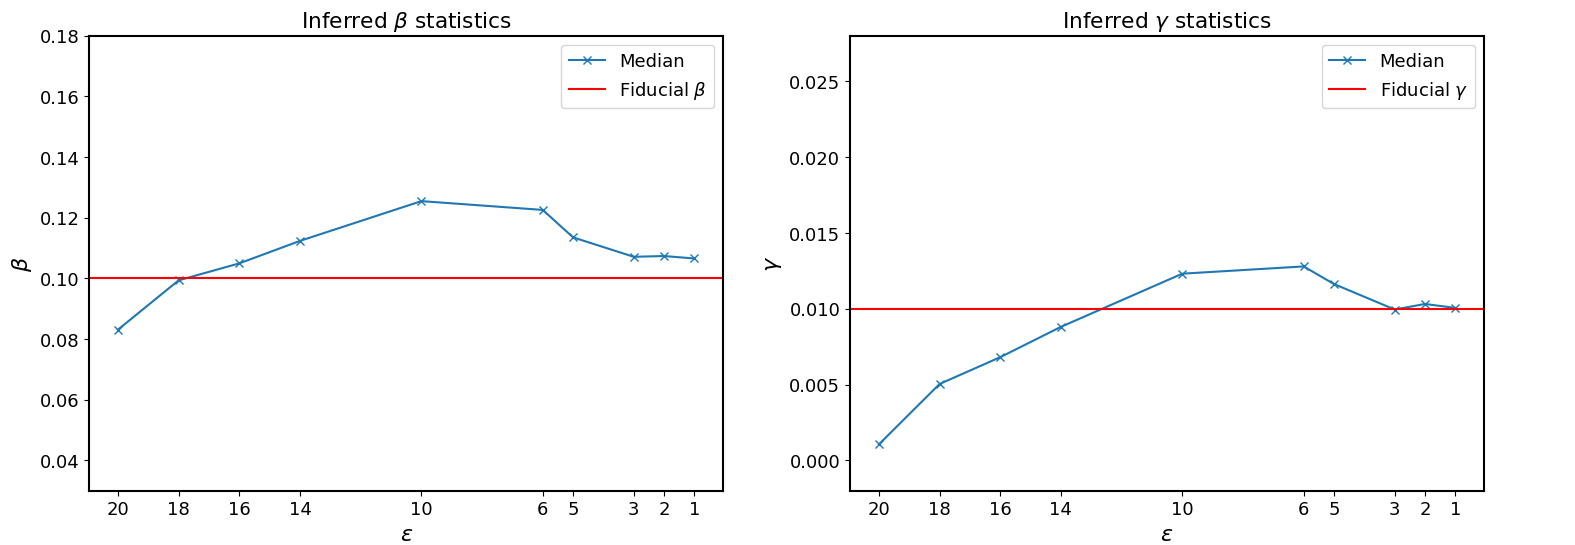

In [17]:
Image.open('./py_code/plot/inferred_median.png')

The relative error for $\varepsilon = 14$ it's $\sim 12\%$, while for $\varepsilon = 5$ it's $\sim 15\%$.

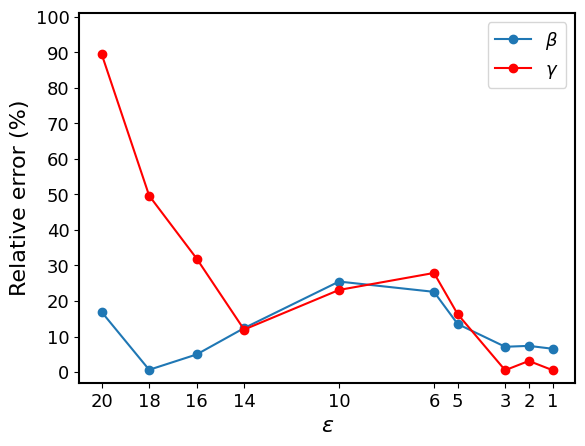

In [10]:
Image.open('./py_code/plot/rel_error.png')

#### **Statistical Inference**

Here we have a comparison of the distributions of the accepted samples. Note that for $\varepsilon = 14$ the sample are distributed on a broader region.  
Another observation is that, although the two threshold lead to a similar relative error and have similar computation time, the distribution of data sampled with $\varepsilon=5$ has a narrower 95% credible interval.

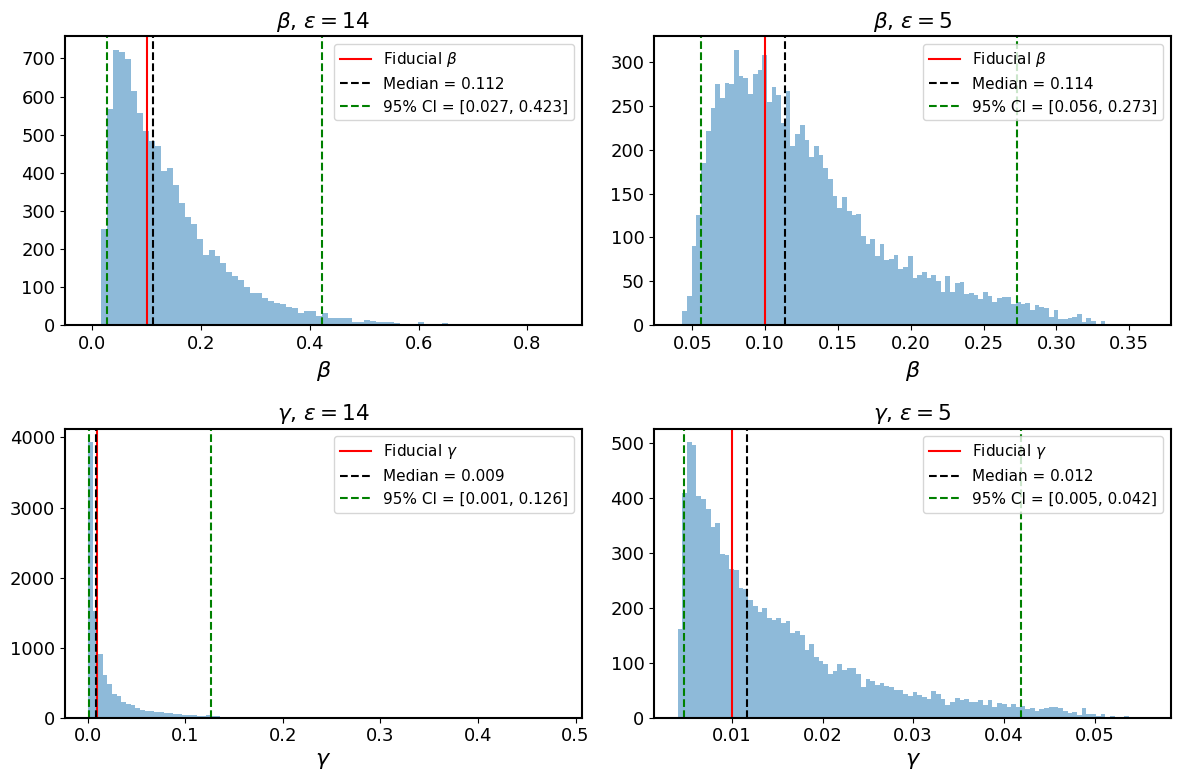

In [11]:
Image.open('./py_code/plot/hist_plot.png')

We can consider also $\varepsilon=1$. The computation time is $\simeq 12.8$ minutes, but we can reach a relative error on $\beta$ of $6.6\%$ and of $0.53\%$ on $\gamma$.  The 95% CI is also narrower.

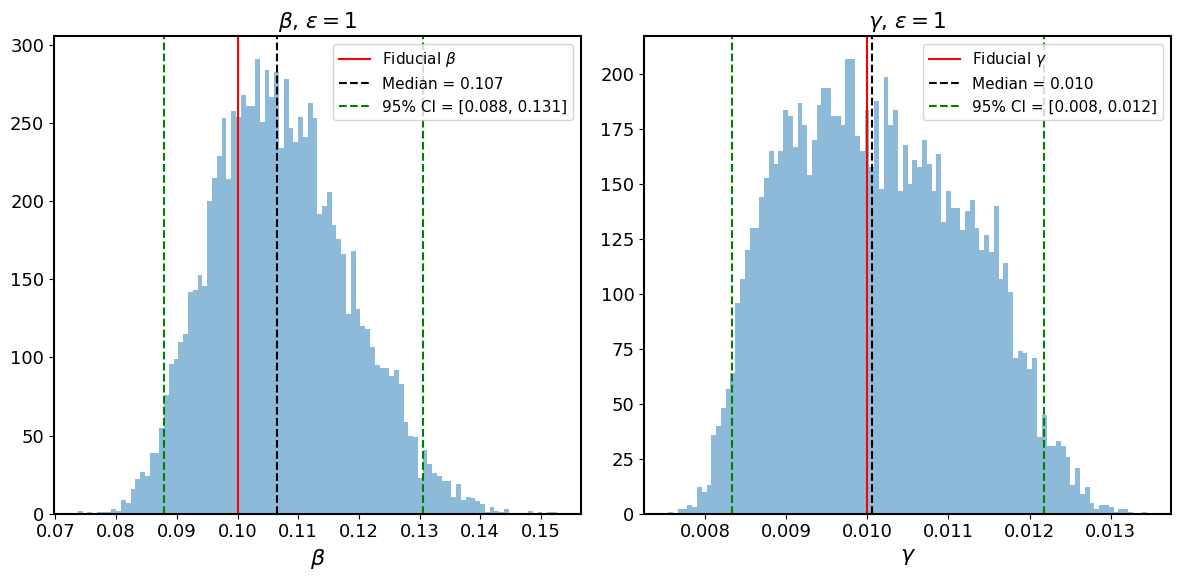

In [16]:
Image.open('./py_code/plot/hist_01.png')

<img src='./py_code/plot/evolution_abc.gif' width="500" align="center">

## ABC - Population Monte Carlo

The disadvantage of the ABC rejection sampler is that the acceptance rate is generally low. To avoid this problem and the fact that long MCMC chains may get stuck in regions of low probability for long periods of time, the so called **ABC Sequential Monte Carlo (ABC-SMC)** was introduced.  

ABC-SMC is an algorithm where successive steps towards the posterior are achieved by applying an importance (or weighted) sampling in the set of parameters values whose distances satisfy a given initial threshold.  

The goal of PMC-ABC is to start with $\theta_0 \sim \pi_0$ and then resample through a series of intermediate auxiliary distribution until you get a sample from $\pi_\epsilon=\mathbb{I}(\rho(d|S)\le\epsilon_T)$  
$\begin{cases}
\pi_0(\theta) \rightarrow \text{prior} & \\
\pi_t(\theta) = \text{intermediate distr} \equiv \pi_0\mathbb{I}(\rho(d|S)\le\epsilon_t) \;\,\text{with}\;\, \epsilon_1\gt...\gt\epsilon_t\gt...\gt\epsilon_T &\\
\pi_T(\theta)\equiv\pi_{\epsilon_T} \Rightarrow \text{target}
\end{cases}$  

The algorithm implemented is from [Toni et al. (2009)](https://doi.org/10.1098/rsif.2008.0172):

<!-- - Algorithm:
1. Initialize $\epsilon_1,...,\epsilon_T$ and set $t=0$ ($t$ is the population indicator)
2. 
    1. Set $i=1$ ($i$ is the particle indicator)
    2. If $t=0$: sample $\theta^{**}\sim\pi_0$ (do this for the number of particles you want); set $w=1$  
    If $t\not=0$: sample $\theta^*$ from previous population at time $t-1$ $(\{\theta^i_{t-1}\})$  
            Sample via SIS with weight at $t-1$  
            After resampling, perturb with $K$ to obtain $\theta^{**}\sim K_t(\theta|\theta^*)$  
                    -) If $\pi_0(\theta^{**})=0$ (”outside prior”) go back to (2.2)  
                    -) Otherwise, simulate dataset $S^*\sim \pi_S(S|\theta^{**})$  
        
        $$
        \begin{cases}
        \text{If}\,\; \rho(d|S^*)\le\epsilon_t \;\, \text{accept} \\
        \text{Otherwise go back to (2.b)}
        \end{cases}
        $$
        
3. 
    1. Set $\theta^i_t=\theta^{**}$, which is distributed according to the auxiliary distribution
    2. Calculate weights for SIS
        
        $$
        \text{unnormalized}\;\,w_t^i=\begin{cases}
        1 &\text{if}\;\,t=0 \\
        \frac{\pi_0(\theta_t^i)}{\sum_i w^i_{t-1}K_t(\theta^i_{t-1},\theta^i_t)} &\text{otherwise}
        \end{cases}
        $$
        
        If $i\lt N$ then $i=i+1$ and go to (2.2)
        
4. Normalize the weights
    
    If $t\lt T$ then $t=t+1$ and go to (2.1) -->

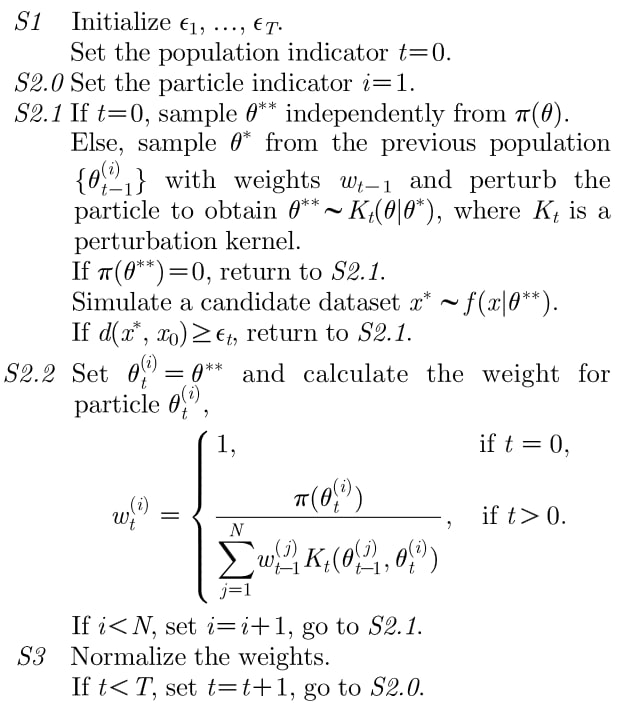

In [18]:
Image.open('./py_code/plot/abc_smc.png')

Here, we choose the perturbation kernel $K_t$ to be a **Gaussian random walk**, with zero mean and standard deviation as the standard deviation of the population at the previous generation.  
Furthermore we decided to iteratively update the threshold $\varepsilon$ by choosing the **75th percentile** of the distances array between observed data and simulation. As for the ABC rejection algorithm, we choose to use as distance measure the Euclidean distance normalized by the population size.  
We "evolved" the system for 15 generations.

#### **Computational Analysis**

We can see that, even though the computation time seems to grow ~ exponentially after generation 6, the total execution time up to the 15th generation is close to 325 seconds, i.e. ~ 5.4 minutes.  
The iterative threshold decrease smoothly and it seems to "land" in a plateau from the 10th generation on.

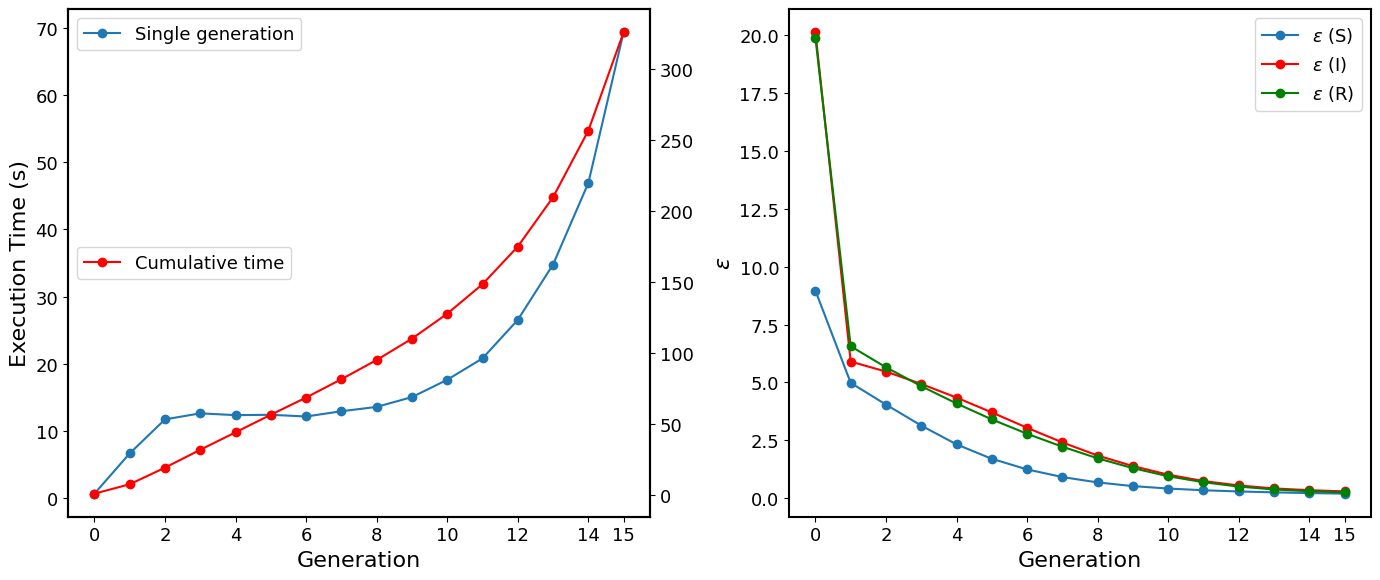

In [21]:
Image.open('./py_code/plot/smc_comp_stats.png')

We see that after 6 generations (less than 20 seconds) for parameter $\beta$ we reach a relative error, between the fiducial and the median of the population, lower than the one found with basic ABC algorithm, $\simeq 6.6\%$.  
The relative error on $\gamma$ remains above the value found with the previous method ($\simeq$ 0.53\%), but maybe with some more generation it could reach it.  

Since the error on $\gamma$ it's very high for the first generation we will compare generation 10 and generation 15.

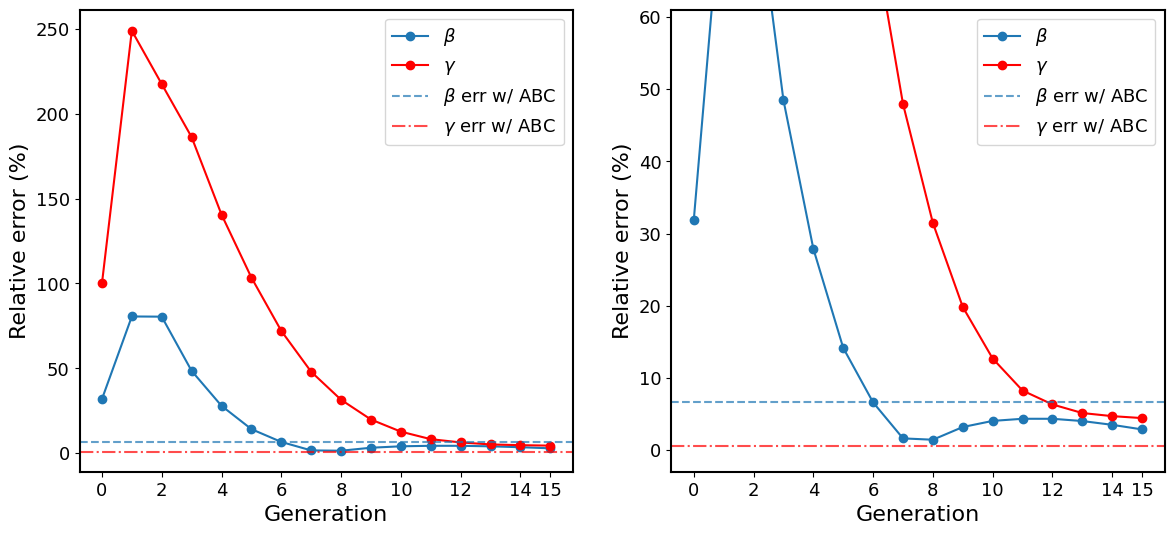

In [22]:
Image.open('./py_code/plot/smc_rel_error.png')

#### **Statistical Inference**

The most notable thing is that at generation 10 we have already a 95% CI that comparable to the CI found before for $\varepsilon=5$ (in half of the computational time!).  

<!-- ABC_beta = 0.217, ABC_gamma = 0.037 -->
<!-- SMC_beta = 0.043, SMC_gamma = 0.0038 -->

If we consider the results at generation 15 we get a 95% CI comparable (or a little narrower) that the one found before for $\varepsilon=1$ (in $\sim 40\%$ of the computtional time!)

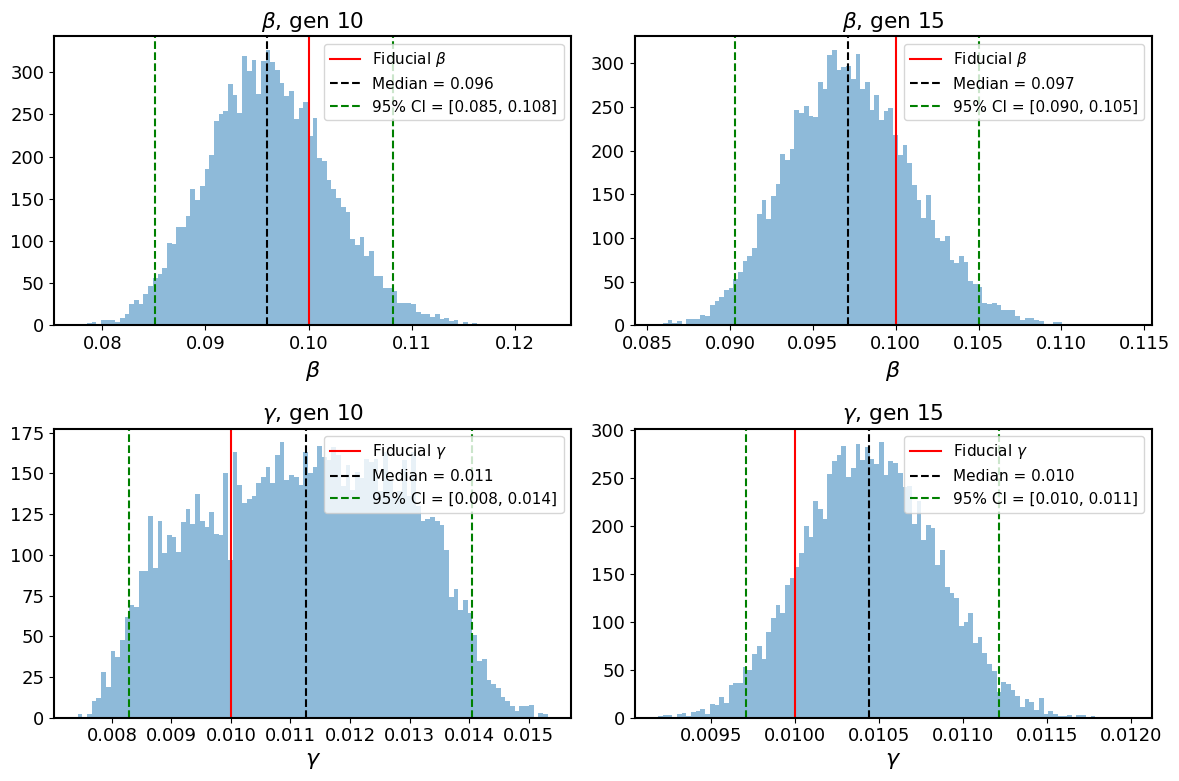

In [23]:
Image.open('./py_code/plot/smc_hist_plot.png')

<img src='./py_code/plot/smc_evolution.gif' width="500" align="center">

## Metropolis-Hastings MCMC

To compare the performance of ABC and ABC-SMC algorithms, we implemented a classical Metropolis(-Hastings) Monte Carlo Markov Chain scheme. This is possible since, in this case, we can actually compute the true posterior distribution. Moreover, our parameter space is a low-dimensional one; therefore, we should not encounter issues with low acceptance rates.

The posterior is:

$$
\pi(\beta, \gamma \mid S_0, I_0, R_0, \Delta I, \Delta R) \propto \pi(\beta) \times \pi(\gamma) \times \prod_{t=1}^{T} P(\Delta I_t \mid S_{t-1}, I_{t-1}, \beta) \times \prod_{t=1}^{T} P(\Delta R_t \mid I_{t-1}, \gamma)
$$

where $\pi(.)$ are the priors on the parameters, and $P(.)$ are the binomial likelihood functions that evolve the model through the stochastic terms $\Delta I, \Delta R$.


### **Statistical Inference**

#### Trace plot of a chain for $\beta$ and $\gamma$

The chain was run for $10^5$ iterations and it took $\sim 43$ minutes.

[comment]: <> (Chain 1 acceptance rate: 1.72%)
[comment]: <> (Chain 2 acceptance rate: 1.81%)
[comment]: <> (Chain 3 acceptance rate: 1.68%)

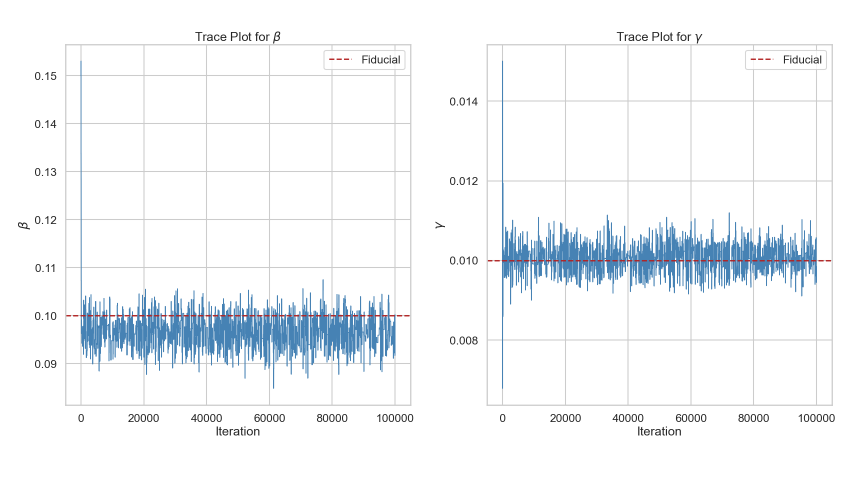

In [25]:
Image.open('./py_code/plot/Chain_TracePlot_Beta_Gamma_600giorni.png')

#### Autocorrelation plot for $\beta$ and $\gamma$

The autocorrelation plot shows that at lag 130 the autocorrelation reaches the threshold value of 0.1 for $\beta$ and at lag 115 for $\gamma$.

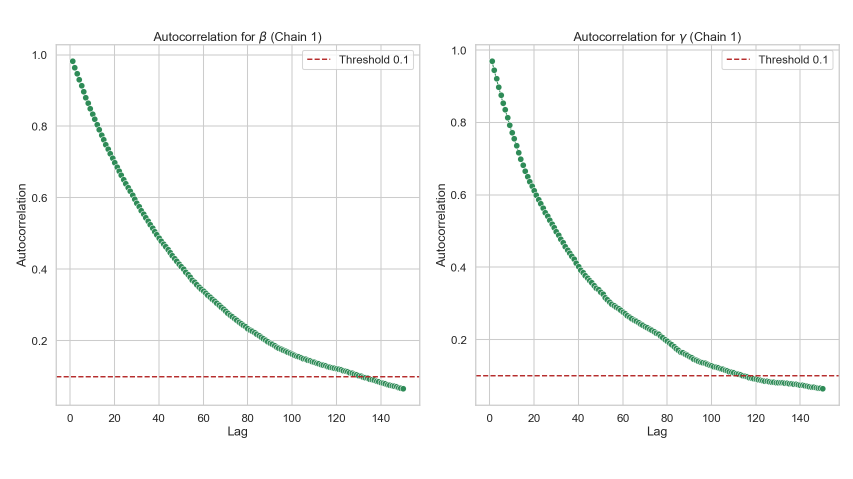

In [26]:
Image.open('./py_code/plot/Autocorrelation_lag150_Beta_Gamma_600giorni.png')

#### Histogram plot of a chain for $\beta$ and $\gamma$

In the histogram plot for the two parameter we can obtain the following results:
 - $\beta$ Relative error: $3.51$%
 - $\beta$ Median: $0.0965$
 - $\beta$ $95$% C.I.: $[0.0907, 0.1029]$
 
 - $\gamma$ Relative error: $0.47$%
 - $\gamma$ Median: $0.01$
 - $\gamma$ $95$% C.I.: $[0.0094, 0.0106]$

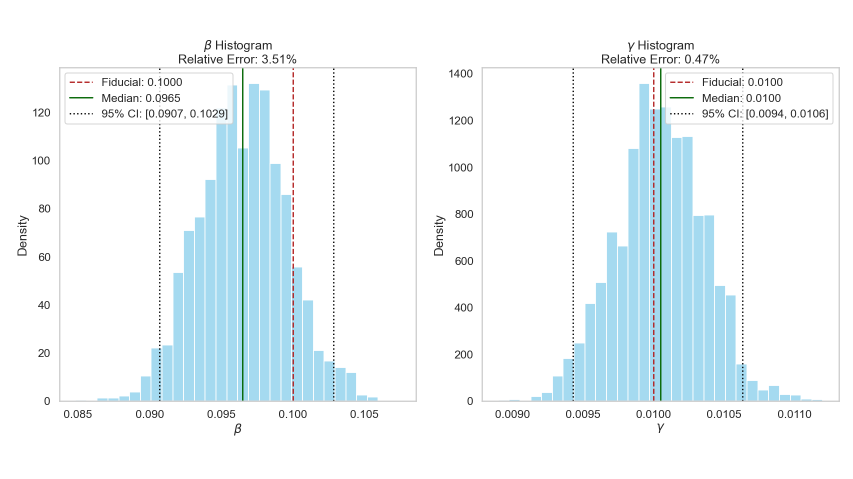

In [27]:
Image.open('./py_code/plot/Chain_Histogram_Beta_Gamma_600giorni.png')

### **Gelman-Rubin (G-R) Test: Assessing MCMC Convergence**


### Introduction to the G-R Test

- **Purpose**: The Gelman-Rubin (G-R) test is a diagnostic tool used to assess the convergence of Markov Chain Monte Carlo (MCMC) chains.
- **Key Idea**: It compares the variance within individual chains to the variance between chains to determine if the chains have converged to the same distribution.



### Why is the G-R Test Important?

- **Convergence**: Ensures that the MCMC chains have reached a stationary distribution.
- **Mixing**: Checks if different chains are exploring the same parameter space.
- **Reliability**: Helps in determining if the sampled points are representative of the posterior distribution.



### The G-R Test Formula

The G-R test is based on the following quantities:

1. **Within-chain variance (W)**:
   $$
   W = \frac{1}{M} \sum_{J=1}^{M} w_J
   $$
   where $ w_J = \frac{1}{n-1} \sum_{i=1}^{n} (\theta_i^J - \bar{\theta}^J)^2 $ is the variance of chain $J$ .

2. **Between-chain variance (B/n)**:
   $$
   B/n = \frac{1}{M-1} \sum_{J=1}^{M} (\bar{\theta}^J - \bar{\theta})^2
   $$
   where $ \bar{\theta}^J $ is the mean of chain $ J $, and $ \bar{\theta} $ is the overall mean across all chains.

3. **Pooled variance (V)**:
   $$
   \hat{V} = \frac{n-1}{n} W + \frac{B}{n}
   $$
   This is a weighted average of the within-chain and between-chain variances.

4. **Gelman-Rubin statistic (R)**:
   $$
   \hat{R} = \frac{\hat{V}}{W}
   $$
   This ratio compares the pooled variance to the within-chain variance.



### Interpretation of the G-R Statistic

- **Good Mixing/Convergence**: 
  $$
  \hat{R} \approx 1
  $$
  Indicates that the chains are mixing well and have converged to the same distribution.

- **Poor Mixing/Convergence**:
  $
  \hat{R} > 1
  $
  Suggests that the chains have not fully explored the parameter space or have not converged.




### Limitations of the G-R Test

- **Bimodal Distributions**: The G-R test may fail to detect convergence issues in cases where the posterior has multiple modes (e.g., bimodal distributions).
- **High Dimensionality**: In high-dimensional parameter spaces, the test may not capture all convergence issues, especially if the chains are stuck in different regions.



---

#### $\beta$,$\gamma$ plane trace plot and Gelman-Rubin Test Results

In the figure below it is possible to notice how, even starting from different initial values, all the 3 chains lead to the region of the fiducial value for each parameter.

The results for the G-R are:
 - Gelman-Rubin $\hat R$ for beta: 1.0003
 - Gelman-Rubin $\hat R$ for gamma: 1.0011

So, the chains are **well mixed** and have **reached convergence properly**.

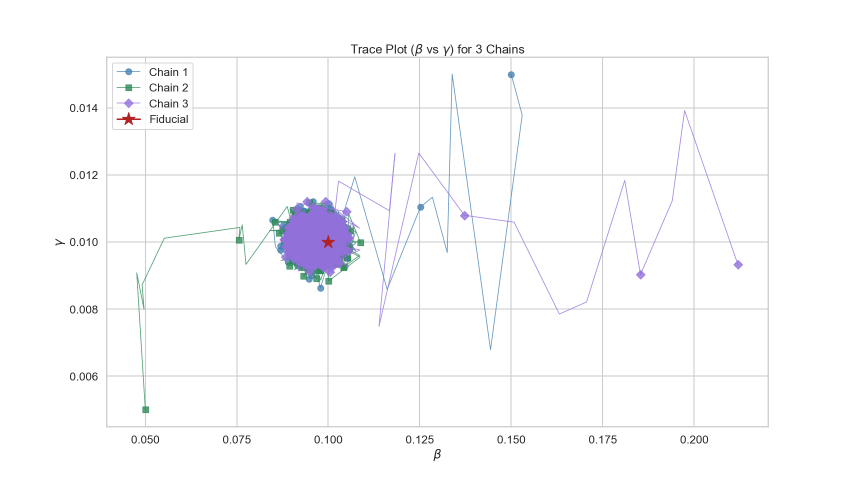

In [28]:
Image.open('./py_code/plot/Chains_TracePlot_Beta_Gamma_600giorni.png')

## Conclusions

In the context of the SIR model, the statistical inference of the parameters $\beta$ and $\gamma$ using three different algorithms has led to these results: 
- A classic M-H MCMC takes $~sim 43$ min to be run in order to obtain enough ~uncorrelated samples, because of the high number of correlated samples.
- The basic ABC and the ABC-SMC are valuable methods in this context, obtaining comparable results to the MCMC in a fraction of time. In particular the ABC-SMC at its 15th generation obtained a comparable result with the value of $\beta$ and $\gamma$ found using the MCMC. Furthermore, the 95% CI are comparable to the MCMC's ones. The time taken to obtain those results is just $\sim 12\%$ of the time taken by the MCMC.  

Although the results look promising, there is a need to keep in mind that the SIR model used in this project is rather simple. Such fast and "accurate" convergence is, in principle, not guaranteed for more complex models.